In [774]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn import linear_model
from scipy.optimize import curve_fit
import math
import os
import openpyxl
%matplotlib inline

In [775]:
def dataToImg(zData,std_show=False):
  mean = np.mean(zData)
  std = np.std(zData)
  if std_show:
    print(std)
  if std < 0.001:
    std = 0.001
  data = (zData-mean)/std
  data_sigmoid = 1/(1+np.exp(-data))
  zDataImg = data_sigmoid*255
  cv2.cvtColor(zDataImg, cv2.COLOR_BGR2RGB)
  return zDataImg

In [776]:
def xlsx_experimentalCondition(filename):
    wb = openpyxl.load_workbook(filename)
    sheet = wb['Sheet1']

    it = sheet.iter_rows(min_row=1,min_col=1,max_row=50,max_col=10)

    data = []
    for row in it:
        r = []
        for cell in row:
            r.append(cell.value)
        data.append(r)
    df = pd.DataFrame(data)
    df = df.dropna(how='all',axis=0)
    df = df.dropna(how='all',axis=1)
    df = pd.Series(df[1].values,index = df[0].values)
    return df

def xlsx_to_df(filename,type='after'):
    wb = openpyxl.load_workbook(filename)
    sheet = wb['Sheet1']

    if type == 'after':
        it = sheet.iter_rows(min_row=100,min_col=1,max_row=2000,max_col=2000)
    else:
        it = sheet.iter_rows(min_row=2100,min_col=1,max_row=4200,max_col=2000)

    data = []
    for row in it:
        r = []
        for cell in row:
            r.append(cell.value)
        data.append(r)
    df = pd.DataFrame(data)
    df = df.dropna(how='all',axis=0)
    df = df.dropna(how='all',axis=1)
    value = df.values
    value=value.astype(np.float32)
    return value,df

## 分析処理

In [777]:
# @title class { display-mode: "form" }
class resultData:
  def __init__(self,zData_after,zData_before,exCond):
    self.after=zData_after
    self.before=zData_before
    self.div = zData_after-zData_before

    self.exCond = exCond
    self.R=exCond['R']
    self.theta=exCond['theta']

    self.data_span=exCond['data_span']
    self.x_size = zData_after.shape[0]
    self.y_size = zData_after.shape[1]

    self.depthThre = None
    self.start_fitting = None
    self.first_touch = None
    self.first_touch_index = None
    self.depthCenter = None
    self.depthCenter_index = None
    self.tmax_fit =None
    self.a = None
    self.b = None

    self.X = None
    self.Y = None

    self.theoricalData_z =None
    self.theoricalData_cast_xy = None

  def plot(self,num):
    if type(num) == np.ndarray:
      result = num/self.data_span
    else:
      result = round(num/self.data_span)
    
    result=int(result)
    return result

  def measure(self,num):
    result = num*self.data_span
    return result


  def imshow(self,data=None,figsize=(5, 5), dpi=100,aspect=1,plot=True):
    fig = plt.figure(figsize=figsize, dpi=dpi)
    if plot:
      extent = (0, data.shape[1], 0,data.shape[0])
    else:
      extent = (0, data.shape[1]*self.data_span, 0,data.shape[0]*self.data_span)

    plt.imshow(dataToImg(data), aspect=aspect,cmap = "gray", origin='lower',extent=extent)


  def get_cross_section(self,data,line,axis=1,plot=True,show=False):
    if axis == 0:
      x_y = np.arange(data.shape[0])
      z = data[:,line]
    elif axis == 1:
      x_y = np.arange(data.shape[1])
      z = data[line]
    if not plot:
      x_y = x_y*self.data_span
    
    if show:
      plt.plot(x_y,z)

    return x_y,z
  
  def cut_line(self,line,edge,plot=True):
    if not plot:
      edge = self.plot(edge)
    line = line[edge[0]:edge[1]]
    return line
    

  
    



  def profileCurve(self,x,a,tmax):
    return -(tmax-(self.R-np.sqrt(self.R**2-(x-a)**2)))

  def liner(self,x,a,b):
    return a*x+b
  def liner2(self,x,b):
    a=-0.005236
    return a*x+b
  
  def liner3(self,x,b,c):
    a=-0.005236
    t = -(a*x+b)
    return a*x+b+c*t**(3/2)
  
  def liner4(self,x,b,c=0.20):
    a=-0.005236
    t = -(a*x+b)
    return a*x+b+c*t**2
  
  def liner5(self,x,b,c):
    a=-0.005236
    t = -(a*x+b)
    R = self.R
    s = 1/2*(R**2)*np.arccos(1-t/R)-1/2*np.sqrt(2*R*t)*(R-t)
    return a*x+b+c*s

  def get_first_touch_real(self):
    self.first_touch = self.measure(self.start_fitting)+self.depthThre/np.tan(self.theta*np.pi/180)
    self.first_touch_index = self.plot(self.measure(self.start_fitting)+self.depthThre/np.tan(self.theta*np.pi/180))
  
  def get_first_touch(self):
    self.first_touch=self.b/-self.a
    self.first_touch_index = self.plot(self.first_touch)
    self.b = 0
  
  def get_xAxis(self):
    x = np.arange(self.after.shape[0])*self.data_span
    self.X = x-self.first_touch

  def get_yAxis(self):
    y = np.arange(self.after.shape[1])*self.data_span
    self.Y = y-self.depthCenter


  def fit(self,func,x,z,param_init):
    """
    func:dataに近似したい任意の関数
    data:データ
    param_init:パラメータの初期値
    popt:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    popt,pocv=curve_fit(func, x, z,param_init)
    if func == self.profileCurve:
      self.depthCenter = popt[0]
      self.tmax_fit = popt[1]
      # self.R = popt[2]
    elif func == self.liner:
      self.a = popt[0]
      self.b = popt[1]
      # self.b = popt[0]
    elif func == self.liner2:
      self.b = popt[0]

    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    return popt

  def getTheorcalData(self):
    theoricalData_z = np.zeros((self.x_size,self.y_size))
    theoricalData_cast_xy = np.zeros((self.x_size,self.y_size))

    for i in range(self.x_size):
      x_i = self.X[i]
      tmax = -self.liner(x_i,self.a,self.b)
      for j in range(self.y_size):
        if self.R/2<np.abs(self.Y[j]-self.depthCenter):
          theoricalData_z[i][j] = self.before[i][j]
        else:
          z_theory = self.profileCurve(self.Y[j],0,tmax)
          if z_theory < self.before[i][j]:
            theoricalData_z[i][j] = z_theory
            theoricalData_cast_xy[i][j] = 1
          else:
            theoricalData_z[i][j] = self.before[i][j]

    self.theoricalData_z = theoricalData_z
    self.theoricalData_cast_xy = theoricalData_cast_xy

    return theoricalData_z
  
  




In [778]:
def surface_smoothing(zData,per = 1,roop = 10):
    n = int(min(zData.shape)*per/100)
    print(n)
    # 4x4配列で値が1/16の畳込フィルタ要素を用意
    kernel = np.ones((n+1,n+1)) /n**2


    roopData = cv2.filter2D(zData,-1,kernel)

    for i in range(roop):
        # 畳み込み操作
        roopData = cv2.filter2D(roopData,-1,kernel)                                 
    
    return roopData

def smooth_line(data,roop=1,smooth_num=5):
    data_smooth=data.copy()
    for h in range(roop):
      for i in range(len(data)):
        if not (i<=smooth_num or i>=len(data)-smooth_num-1):
          data_smooth[i] = np.mean(data_smooth[i-smooth_num:i+smooth_num])
        else:
          data_smooth[i]=data[i]
    return data_smooth

In [779]:
folder_name = "csv_画像一致後データ/"
child_folder_name = '240830_角度(0.3)_速度(100,1000,3000)_油(PAO,VG40,VG400)_R(800)/'
filename = folder_name+child_folder_name+'F3000_VG400.xlsx'
exCond = xlsx_experimentalCondition(filename)
zData_after,_ = xlsx_to_df(filename,'after')
zData_before,_ = xlsx_to_df(filename,'before')

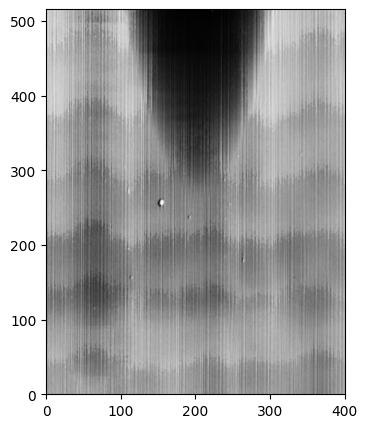

In [780]:
rd =resultData(zData_after,zData_before,exCond)
# rd =resultData(data1,data2)
rd.imshow(rd.after)

In [781]:
def get_edge(line,thre=-0.1):
    left = None
    right = None
    for i in range(len(line)):
        if line[i] < thre:
            left = i
            break
    for i in reversed(range(len(line))):
        if line[i] < thre:
            right = i
            break
    return left,right

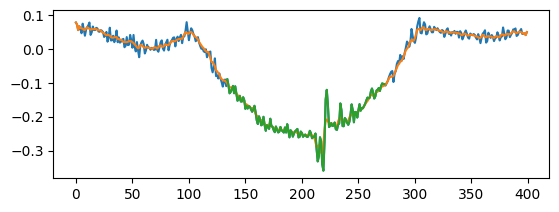

In [782]:
fit_point = -3
y_fitting,z_fitting = rd.get_cross_section(rd.after,fit_point)
z_fitting_smooth = smooth_line(z_fitting,roop=1,smooth_num=3)
left,right=get_edge(z_fitting_smooth)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
# y_fitting = rd.measure(y_fitting)
# plt.plot(y_fitting,z_fitting_smooth)
plt.plot(y_fitting,z_fitting)
plt.plot(y_fitting,z_fitting_smooth)
plt.plot(y_fitting[left:right],z_fitting[left:right])

depthCenter 50.622059676851336
tmax_fit 0.26491268578164795
depth_Center_index 202


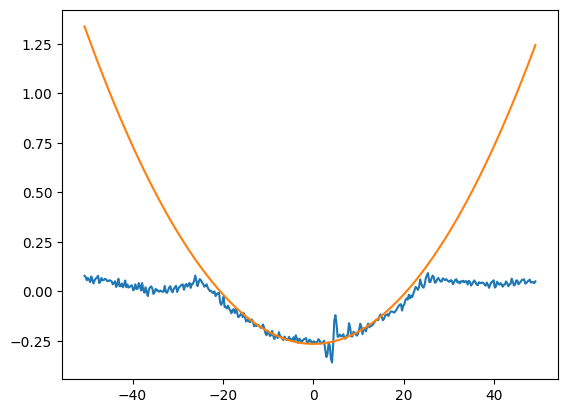

In [783]:
y_fitting,z_fitting = rd.get_cross_section(rd.after,fit_point,plot=False)
param_init=[y_fitting[int(len(y_fitting)/2)],1]
depthCenter,tmax_fit= rd.fit(rd.profileCurve,y_fitting[left:right],z_fitting[left:right],param_init)
print("depthCenter",depthCenter)
print("tmax_fit",tmax_fit)
depth_Center_index = rd.plot(depthCenter)
print("depth_Center_index",depth_Center_index)

z_predictData = rd.profileCurve(y_fitting,depthCenter,tmax_fit)

fig = plt.figure()
# plt.ylim(-1.5, 2.5)
# plt.xlim(-75, 75)
plt.plot(y_fitting-rd.depthCenter, z_fitting)
plt.plot(y_fitting-rd.depthCenter, z_predictData)

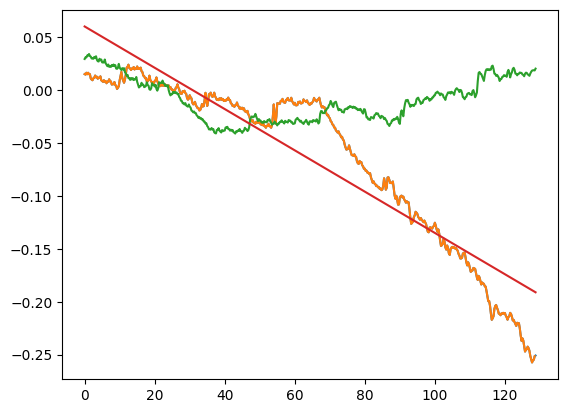

In [784]:
y_fitting,z_fitting_after = rd.get_cross_section(rd.after,depth_Center_index,axis=0,plot=False)
y_fitting,z_fitting_before = rd.get_cross_section(rd.before,depth_Center_index,axis=0,plot=False)
z_fitting_smooth = smooth_line(z_fitting_after,roop=3,smooth_num=10)
rd.depthThre = -0.3
start_fitting,_=get_edge(z_fitting_smooth,thre=rd.depthThre)
rd.start_fitting =start_fitting
param_init=[0,0]
a,b = rd.fit(rd.liner,y_fitting[start_fitting:-1],z_fitting_after[start_fitting:-1],param_init)
z_predictData = rd.liner(y_fitting,a,b)
fig = plt.figure()

plt.plot(y_fitting, z_fitting_after)
plt.plot(y_fitting[start_fitting:-1], z_fitting_after[start_fitting:-1])
plt.plot(y_fitting, z_fitting_before)
plt.plot(y_fitting, z_predictData)

In [785]:
rd.get_first_touch()
rd.get_xAxis()
rd.get_yAxis()
theoricalData_z = rd.getTheorcalData()

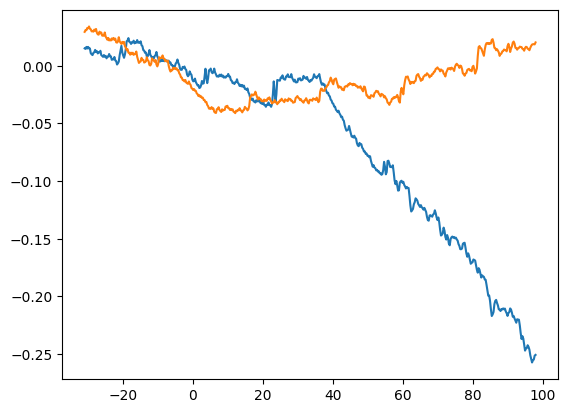

In [786]:
y_fitting,z_fitting_after = rd.get_cross_section(rd.after,depth_Center_index,axis=0,plot=False)
y_fitting,z_fitting_before = rd.get_cross_section(rd.before,depth_Center_index,axis=0,plot=False)

plt.plot(rd.X, z_fitting_after)
plt.plot(rd.X, z_fitting_before)

export = pd.DataFrame([rd.X,z_fitting_before,z_fitting_after])
export = export.T
export.to_excel('temp/0129/{}.xlsx'.format(rd.exCond['name']))

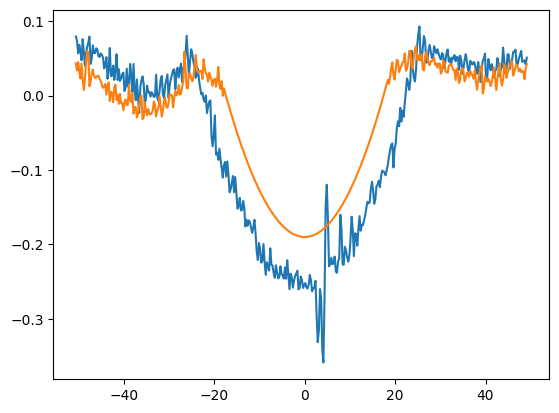

In [787]:
line=-3
y_fitting,z_fitting = rd.get_cross_section(rd.after,line,plot=False)
y_fitting,z_fitting_theorical = rd.get_cross_section(rd.theoricalData_z,line,axis = 1)
fig = plt.figure()
plt.plot(rd.Y,z_fitting)
plt.plot(rd.Y,z_fitting_theorical)

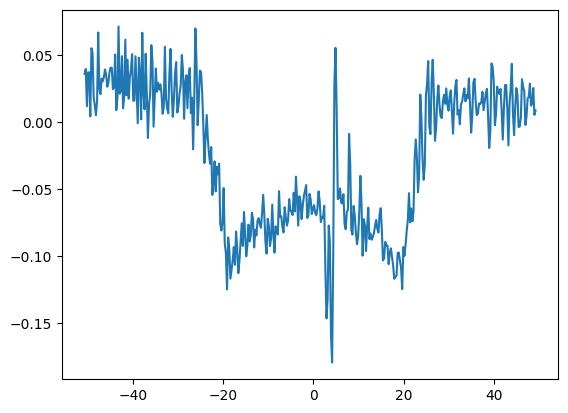

In [788]:
plt.plot(rd.Y,z_fitting-z_fitting_theorical)

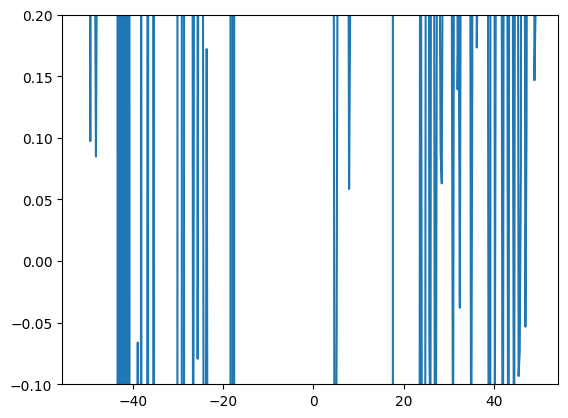

In [789]:
plt.ylim(-0.1, 0.2)
plt.plot(rd.Y,(z_fitting-z_fitting_theorical)/(z_fitting_theorical))

In [790]:
rd.a

-0.0019513804756733611

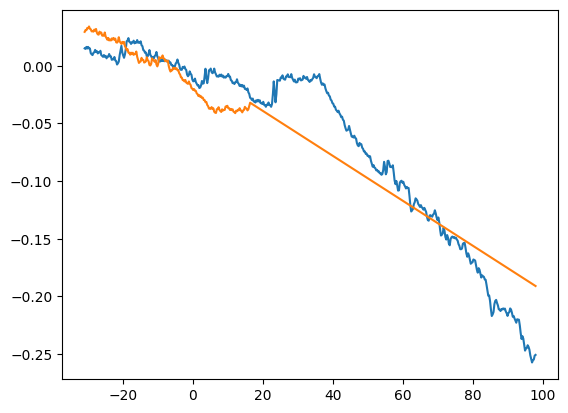

In [791]:
line=rd.plot(rd.depthCenter)
y_fitting,z_fitting = rd.get_cross_section(rd.after,line,axis = 0)
# y_fitting,z_fitting_before = rd.get_cross_section(rd.before,line,axis = 0)
y_fitting,z_fitting_theorical = rd.get_cross_section(rd.theoricalData_z,line,axis = 0)
fig = plt.figure()
plt.plot(rd.X,z_fitting)
# plt.plot(rd.X,z_fitting_before)
plt.plot(rd.X,z_fitting_theorical)

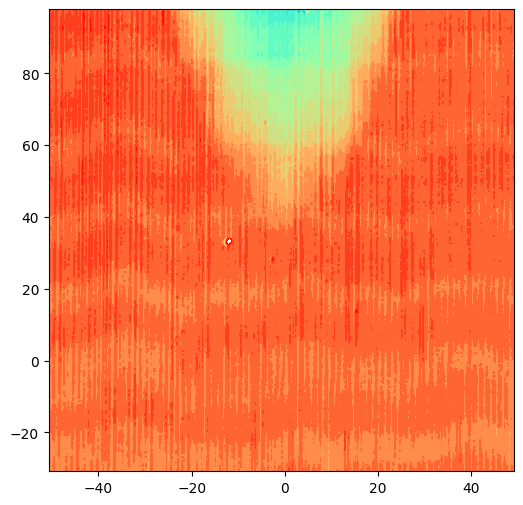

In [799]:
min_div = -0.5
max_div = 0.1
num_line = 7
num_color = 20
interval_line = np.linspace(min_div,max_div,num_line)
interval_color = np.linspace(min_div,max_div,num_color)
X, Y = np.meshgrid(rd.Y, rd.X)
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.contourf(X, Y, rd.div,interval_color,cmap='rainbow')
# ax = plt.colorbar(label="dep")
# plt.contourf(X, Y,rd.theoricalData_cast_xy,[0.1,0.5,0.9],colors='black',origin='lower')

In [800]:
rd.a

-0.0019513804756733611

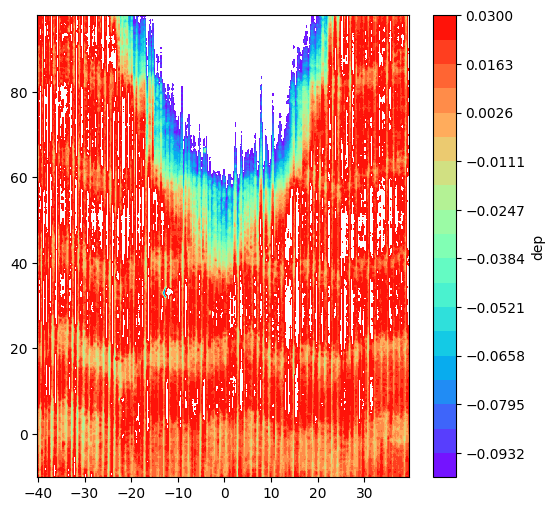

In [802]:
min_div = -0.1
max_div = 0.03
num_line = 7
num_color = 20


w =40
t = 140
b =10
t = t
b = b

ml = rd.plot(rd.depthCenter-w)
mr = rd.plot(rd.depthCenter+w)
mt = rd.plot(rd.first_touch+t)
mb = rd.plot(rd.first_touch-b)
# [rd.plot(-10):rd.plot(100)]
X, Y = np.meshgrid(rd.Y[ml:mr], rd.X[mb:mt])
Y = Y


after_focas = rd.div[mb:mt,ml:mr]
# border_real_focas = border_real[mb:mt,ml:mr]
# theorical_focas = theorical[mb:mt,ml:mr]




interval_line = np.linspace(min_div,max_div,num_line)
interval_color = np.linspace(min_div,max_div,num_color)
# X, Y = np.meshgrid(rd.Y, rd.X)
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.contourf(X, Y, after_focas,interval_color,cmap='rainbow')
ax = plt.colorbar(label="dep")
# plt.contourf(X, Y,rd.theoricalData_cast_xy,[0.1,0.5,0.9],colors='black',origin='lower')

In [795]:

def create_folder_if_not_exists(folder_path):
    # フォルダが存在しない場合は作成する
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"フォルダ '{folder_path}' を作成しました。")
    else:
        print(f"フォルダ '{folder_path}' は既に存在します。")
        

def check_and_write_file(file_path):
    # ファイルが存在するかどうかをチェック
    if os.path.exists(file_path):
        # ファイルが存在する場合、書き替えるかどうかを確認
        overwrite = input(f"ファイル '{file_path}' は既に存在します。上書きしますか？ (y/n): ")
        if overwrite.lower() != 'y':
            print("ファイルの上書きを中止しました。")
            return
    # # ファイルに書き込む
    # with open(file_path, 'w', encoding='utf-8') as f:
    #     f.write(content)
    # print(f"ファイル '{file_path}' に書き込みました。")

In [796]:

folder_name = 'pickle/'+'{}_{}'.format(rd.exCond['day'],rd.exCond['テーマ'])

create_folder_if_not_exists(folder_name)

# Excelファイルとして保存
pickle_path = '{}/{}.pickle'.format(folder_name,rd.exCond['name'])

check_and_write_file(pickle_path)

df = pd.DataFrame(rd.__dict__.items())
df.set_index(0, inplace = True)

df.to_pickle(pickle_path)


フォルダ 'pickle/240830_角度(0.3)_速度(100,1000,3000)_油(PAO,VG40,VG400)_R(800)' は既に存在します。
ファイルの上書きを中止しました。
